<a href="https://colab.research.google.com/github/Soyeon20220610/githubTest/blob/main/C2W2_Optimization_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#stochastic gradient descent, momentum, RMSProp and Adam
#use random minibatches to accelerate convergence and improve optimization
!pip install dlai_tools

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import math
import sklearn
import sklearn.datasets

from opt_utils_v1a import load_params_and_grads, initialize_parameters, forward_propagation, backward_propagation
from opt_utils_v1a import compute_cost, predict, predict_dec, plot_decision_boundary, load_dataset
from copy import deepcopy
from testCases import *
from public_tests import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Batch gradient Descent = Gradient Descent

In [2]:
def update_parameters_with_gd(parameters, grads, learning_rate):
  L = len(parameters)//2
  for l in range(1,L+1):
    parameters['W'+str(l)] = parameters['W'+str(l)] - learning_rate*grads['dW'+str(l)]
    parameters['b'+str(l)] = parameters['b'+str(l)] - learning_rate*grads['db'+str(l)]
  return parameters

In [3]:
parameters, grads, learning_rate = update_parameters_with_gd_test_case()
learning_rate = 0.01
parameters = update_parameters_with_gd(parameters, grads, learning_rate)

print("W1 =\n" + str(parameters["W1"]))
print("b1 =\n" + str(parameters["b1"]))
print("W2 =\n" + str(parameters["W2"]))
print("b2 =\n" + str(parameters["b2"]))

update_parameters_with_gd_test(update_parameters_with_gd)

W1 =
[[ 1.63535156 -0.62320365 -0.53718766]
 [-1.07799357  0.85639907 -2.29470142]]
b1 =
[[ 1.74604067]
 [-0.75184921]]
W2 =
[[ 0.32171798 -0.25467393  1.46902454]
 [-2.05617317 -0.31554548 -0.3756023 ]
 [ 1.1404819  -1.09976462 -0.1612551 ]]
b2 =
[[-0.88020257]
 [ 0.02561572]
 [ 0.57539477]]
All test passed


Stochastic Gradient Descent : (Batch) Gradient Descent와 다르게, gradients update 하기 전에 1개의 training example만을 사용한다.

mini-batch gradient descent :   SGD와 다르게 multiple samples 한 꺼번에 

Batch gradient descent 보다 더욱 oscillate하지만, minimum cost로 더 빠르게 이동하는 장점이 있다.

1. SGD



```
X = data_input
Y = labels
m = X.shape[1]  # Number of training examples
parameters = initialize_parameters(layers_dims)
for i in range(0, num_iterations):
    cost_total = 0
    for j in range(0, m):
        # Forward propagation
        a, caches = forward_propagation(X[:,j], parameters)
        # Compute cost
        cost_total += compute_cost(a, Y[:,j])  # Cost for one training example
        # Backward propagation
        grads = backward_propagation(a, caches, parameters)
        # Update parameters
        parameters = update_parameters(parameters, grads)
    # Compute average cost
    cost_avg = cost_total / m```



2. Batch Gradient Descent



```
X = data_input
Y = labels
m = X.shape[1]  # Number of training examples
parameters = initialize_parameters(layers_dims)
for i in range(0, num_iterations):
    # Forward propagation
    a, caches = forward_propagation(X, parameters)
    # Compute cost
    cost_total = compute_cost(a, Y)  # Cost for m training examples
    # Backward propagation
    grads = backward_propagation(a, caches, parameters)
    # Update parameters
    parameters = update_parameters(parameters, grads)
    # Compute average cost
    cost_avg = cost_total / m```



3. Mini-batch Gradient Descent

mini-batch 만들기 위한 2가지 단계

-shuffling

-Partitioning

-mini batch size 는 2의 제곱 수로 해야 함.

In [4]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    
    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[1]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]              # X 행렬의 column의 순서를 바꿔줌 = (eg. m=1 인 column이 m=5 인 column과 자리 change)
    shuffled_Y = Y[:, permutation].reshape((1, m))
    
    inc = mini_batch_size  # 64

    # Step 2 - Partition (shuffled_X, shuffled_Y).
    num_complete_minibatches = math.floor(m / mini_batch_size) 
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, mini_batch_size*k : mini_batch_size*(k+1)]   # column 0~63, 64~127,... 가 각각 한개의 mini batch 가 됨
        mini_batch_Y = shuffled_Y[:, mini_batch_size*k : mini_batch_size*(k+1)]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # For handling the end case (last mini-batch < mini_batch_size i.e less than 64)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, (k+1)*mini_batch_size:]
        mini_batch_Y = shuffled_Y[:, (k+1)*mini_batch_size:]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [5]:
np.random.seed(1)
mini_batch_size = 64
nx = 12288
m = 148
X = np.array([x for x in range(nx * m)]).reshape((m, nx)).T
Y = np.random.randn(1, m) < 0.5

mini_batches = random_mini_batches(X, Y, mini_batch_size)
n_batches = len(mini_batches)

assert n_batches == math.ceil(m / mini_batch_size), f"Wrong number of mini batches. {n_batches} != {math.ceil(m / mini_batch_size)}"
for k in range(n_batches - 1):
    assert mini_batches[k][0].shape == (nx, mini_batch_size), f"Wrong shape in {k} mini batch for X"
    assert mini_batches[k][1].shape == (1, mini_batch_size), f"Wrong shape in {k} mini batch for Y"
    assert np.sum(np.sum(mini_batches[k][0] - mini_batches[k][0][0], axis=0)) == ((nx * (nx - 1) / 2 ) * mini_batch_size), "Wrong values. It happens if the order of X rows(features) changes"
if ( m % mini_batch_size > 0):
    assert mini_batches[n_batches - 1][0].shape == (nx, m % mini_batch_size), f"Wrong shape in the last minibatch. {mini_batches[n_batches - 1][0].shape} != {(nx, m % mini_batch_size)}"

assert np.allclose(mini_batches[0][0][0][0:3], [294912,  86016, 454656]), "Wrong values. Check the indexes used to form the mini batches"
assert np.allclose(mini_batches[-1][0][-1][0:3], [1425407, 1769471, 897023]), "Wrong values. Check the indexes used to form the mini batches"

print("\033[92mAll test passed!")

All test passed!


In [6]:
t_X, t_Y, mini_batch_size = random_mini_batches_test_case()
mini_batches = random_mini_batches(t_X, t_Y, mini_batch_size)

print ("shape of the 1st mini_batch_X: " + str(mini_batches[0][0].shape))
print ("shape of the 2nd mini_batch_X: " + str(mini_batches[1][0].shape))
print ("shape of the 3rd mini_batch_X: " + str(mini_batches[2][0].shape))
print ("shape of the 1st mini_batch_Y: " + str(mini_batches[0][1].shape))
print ("shape of the 2nd mini_batch_Y: " + str(mini_batches[1][1].shape)) 
print ("shape of the 3rd mini_batch_Y: " + str(mini_batches[2][1].shape))
print ("mini batch sanity check: " + str(mini_batches[0][0][0][0:3]))

random_mini_batches_test(random_mini_batches)

shape of the 1st mini_batch_X: (12288, 64)
shape of the 2nd mini_batch_X: (12288, 64)
shape of the 3rd mini_batch_X: (12288, 20)
shape of the 1st mini_batch_Y: (1, 64)
shape of the 2nd mini_batch_Y: (1, 64)
shape of the 3rd mini_batch_Y: (1, 20)
mini batch sanity check: [ 0.90085595 -0.7612069   0.2344157 ]
 All tests passed.


총 m=148 이었는데, mini batch size = 64 로 해서 64,64,20 으로 3개가 만들어짐

In [7]:
# permutation = shuffle 하는 코드

# P=np.arange(10).reshape(5,2)
# np.random.seed(10)
# print(P)

# P=np.random.permutation(P)    # shuffle
# print('P_shuffle \n',P)

# n=10
# permutation_practice=list(np.random.permutation(n))
# print('permutation_practice \n',permutation_practice)

X_train = np.arange(40).reshape(4,10)    # unit4, number of samples=3
print('X_train \n',X_train)
Y_train = np.arange(10).reshape(1,10)
n=X_train.shape[1]
permutation_practice=list(np.random.permutation(n))
shuffled_X = X_train[:,permutation_practice]
print('shuffled_X \n',shuffled_X)

mini_batch_size = 3
k=0
mini_batch_X = shuffled_X[:,mini_batch_size*k:mini_batch_size*(k+1)]
print('\n mini_batch_X 1 \n',mini_batch_X)

k=1
mini_batch_X = shuffled_X[:,mini_batch_size*k:mini_batch_size*(k+1)]
print('\n mini_batch_X 2 \n',mini_batch_X)

k=2
mini_batch_X = shuffled_X[:,mini_batch_size*k:mini_batch_size*(k+1)]
print('\n mini_batch_X 3 \n',mini_batch_X)

k=3
mini_batch_X = shuffled_X[:,mini_batch_size*k:mini_batch_size*(k+1)]
print('\n mini_batch_X 4 \n',mini_batch_X)

X_train 
 [[ 0  1  2  3  4  5  6  7  8  9]
 [10 11 12 13 14 15 16 17 18 19]
 [20 21 22 23 24 25 26 27 28 29]
 [30 31 32 33 34 35 36 37 38 39]]
shuffled_X 
 [[ 2  8  4  9  1  6  7  3  0  5]
 [12 18 14 19 11 16 17 13 10 15]
 [22 28 24 29 21 26 27 23 20 25]
 [32 38 34 39 31 36 37 33 30 35]]

 mini_batch_X 1 
 [[ 2  8  4]
 [12 18 14]
 [22 28 24]
 [32 38 34]]

 mini_batch_X 2 
 [[ 9  1  6]
 [19 11 16]
 [29 21 26]
 [39 31 36]]

 mini_batch_X 3 
 [[ 7  3  0]
 [17 13 10]
 [27 23 20]
 [37 33 30]]

 mini_batch_X 4 
 [[ 5]
 [15]
 [25]
 [35]]


4. Momentum

mini batch gradient descent 에서 발생하는 oscillate를 줄여주는 방법

* 이전의 gradient의 direction을 변수 v에 저장 ==> 이전단계 gradient 의 exponentially weighted average 이다. 
* 쉽게 이해하자면,  v는 공이 언덕을 굴러가면서 언덕의 방향에 따라 velocity(momentum) 을 쌓아가면서 얻는 velocity

In [8]:
def initialize_velocity(parameters):
  L = len(parameters)//2
  v= {}

  #initialize velocity
  for l in range(1,L+1):
    v['dW'+str(l)] = np.zeros((parameters['W'+str(l)].shape))
    v["db" + str(l)] =np.zeros((parameters['b'+str(l)].shape))

  return v

In [9]:
parameters = initialize_velocity_test_case()

v = initialize_velocity(parameters)
print("v[\"dW1\"] =\n" + str(v["dW1"]))
print("v[\"db1\"] =\n" + str(v["db1"]))
print("v[\"dW2\"] =\n" + str(v["dW2"]))
print("v[\"db2\"] =\n" + str(v["db2"]))

initialize_velocity_test(initialize_velocity)

v["dW1"] =
[[0. 0. 0.]
 [0. 0. 0.]]
v["db1"] =
[[0.]
 [0.]]
v["dW2"] =
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
v["db2"] =
[[0.]
 [0.]
 [0.]]
 All tests passed.


Now, implement the parameters update with momentum. The momentum update rule is, for $l = 1, ..., L$: 

$$ \begin{cases}
v_{dW^{[l]}} = \beta v_{dW^{[l]}} + (1 - \beta) dW^{[l]} \\
W^{[l]} = W^{[l]} - \alpha v_{dW^{[l]}}
\end{cases}\tag{3}$$

$$\begin{cases}
v_{db^{[l]}} = \beta v_{db^{[l]}} + (1 - \beta) db^{[l]} \\
b^{[l]} = b^{[l]} - \alpha v_{db^{[l]}} 
\end{cases}\tag{4}$$

where L is the number of layers, $\beta$ is the momentum and $\alpha$ is the learning rate.

In [10]:
# moment로 parameter update 함

def update_parameters_with_momentum(parameters,grads,v,beta,learning_rate):
  L = len(parameters) // 2
  for l in range(1,L+1):
    v['dW'+str(l)] = beta*v['dW'+str(l)]+(1-beta)*grads['dW'+str(l)]
    v["db" + str(l)] = beta*v['db'+str(l)]+(1-beta)*grads['db'+str(l)]
    parameters['W'+str(l)] = parameters['W'+str(l)] -learning_rate*v['dW'+str(l)]
    parameters["b" + str(l)] = parameters['b'+str(l)] -learning_rate*v['db'+str(l)]

  return parameters, v

In [11]:
parameters, grads, v = update_parameters_with_momentum_test_case()

parameters, v = update_parameters_with_momentum(parameters, grads, v, beta = 0.9, learning_rate = 0.01)
print("W1 = \n" + str(parameters["W1"]))
print("b1 = \n" + str(parameters["b1"]))
print("W2 = \n" + str(parameters["W2"]))
print("b2 = \n" + str(parameters["b2"]))
print("v[\"dW1\"] = \n" + str(v["dW1"]))
print("v[\"db1\"] = \n" + str(v["db1"]))
print("v[\"dW2\"] = \n" + str(v["dW2"]))
print("v[\"db2\"] = v" + str(v["db2"]))

update_parameters_with_momentum_test(update_parameters_with_momentum)

W1 = 
[[ 1.62544598 -0.61290114 -0.52907334]
 [-1.07347112  0.86450677 -2.30085497]]
b1 = 
[[ 1.74493465]
 [-0.76027113]]
W2 = 
[[ 0.31930698 -0.24990073  1.4627996 ]
 [-2.05974396 -0.32173003 -0.38320915]
 [ 1.13444069 -1.0998786  -0.1713109 ]]
b2 = 
[[-0.87809283]
 [ 0.04055394]
 [ 0.58207317]]
v["dW1"] = 
[[-0.11006192  0.11447237  0.09015907]
 [ 0.05024943  0.09008559 -0.06837279]]
v["db1"] = 
[[-0.01228902]
 [-0.09357694]]
v["dW2"] = 
[[-0.02678881  0.05303555 -0.06916608]
 [-0.03967535 -0.06871727 -0.08452056]
 [-0.06712461 -0.00126646 -0.11173103]]
v["db2"] = v[[0.02344157]
 [0.16598022]
 [0.07420442]]
 All tests passed.


In [12]:
def initialize_adam(parameters):
  L = len(parameters) // 2
  v ={}
  s = {}

  for l in range(1,L+1):
    v['dW'+str(l)] = np.zeros((parameters["W" + str(l)].shape))
    v["db" + str(l)] = np.zeros((parameters["b" + str(l)].shape))
    s["dW" + str(l)] = np.zeros((parameters["W" + str(l)].shape))
    s["db" + str(l)] = np.zeros((parameters["b" + str(l)].shape))

  return v,s

In [13]:
parameters = initialize_adam_test_case()

v, s = initialize_adam(parameters)
print("v[\"dW1\"] = \n" + str(v["dW1"]))
print("v[\"db1\"] = \n" + str(v["db1"]))
print("v[\"dW2\"] = \n" + str(v["dW2"]))
print("v[\"db2\"] = \n" + str(v["db2"]))
print("s[\"dW1\"] = \n" + str(s["dW1"]))
print("s[\"db1\"] = \n" + str(s["db1"]))
print("s[\"dW2\"] = \n" + str(s["dW2"]))
print("s[\"db2\"] = \n" + str(s["db2"]))

initialize_adam_test(initialize_adam)

v["dW1"] = 
[[0. 0. 0.]
 [0. 0. 0.]]
v["db1"] = 
[[0.]
 [0.]]
v["dW2"] = 
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
v["db2"] = 
[[0.]
 [0.]
 [0.]]
s["dW1"] = 
[[0. 0. 0.]
 [0. 0. 0.]]
s["db1"] = 
[[0.]
 [0.]]
s["dW2"] = 
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
s["db2"] = 
[[0.]
 [0.]
 [0.]]
 All tests passed.


In [16]:
def update_parameters_with_adam(parameters, grads,v,s,t,learning_rate=0.01, beta1=0.9,beta2 = 0.999, epsilon = 1e-8):
  L = len(parameters) // 2
  v_corrected = {}
  s_corrected = {}
  for l in range(1,L+1):
    #momentum correction
    v['dW'+str(l)] = beta1*v['dW'+str(l)]+(1-beta1)*grads['dW'+str(l)]
    v["db" + str(l)] = beta1*v['db'+str(l)]+(1-beta1)*grads['db'+str(l)]
    v_corrected['dW'+str(l)] = v['dW'+str(l)]/(1-beta1**t) # t=2 로 fixed
    v_corrected['db'+str(l)] = v['db'+str(l)]/(1-beta1**t)
    #RMS prop
    s["dW" + str(l)] = beta2*s['dW'+str(l)]+(1-beta2)*(grads['dW'+str(l)]**2)
    s["db" + str(l)] =beta2*s['db'+str(l)]+(1-beta2)*(grads['db'+str(l)]**2)
    s_corrected["dW" + str(l)] = s['dW'+str(l)]/(1-beta2**t)
    s_corrected["db" + str(l)] = s['db'+str(l)]/(1-beta2**t)
    #update parameters , W, b
    parameters['W'+str(l)] =  parameters['W'+str(l)] - learning_rate * v_corrected['dW'+str(l)]/(np.sqrt(s_corrected['dW'+str(l)])+epsilon)      
    parameters["b" + str(l)] = parameters["b" + str(l)] -learning_rate*v_corrected['db'+str(l)]/(np.sqrt(s_corrected['db'+str(l)])+epsilon)
       
  return parameters, v, s, v_corrected, s_corrected

In [17]:
parametersi, grads, vi, si = update_parameters_with_adam_test_case()

t = 2
learning_rate = 0.02
beta1 = 0.8
beta2 = 0.888
epsilon = 1e-2

parameters, v, s, vc, sc  = update_parameters_with_adam(parametersi, grads, vi, si, t, learning_rate, beta1, beta2, epsilon)
print(f"W1 = \n{parameters['W1']}")
print(f"W2 = \n{parameters['W2']}")
print(f"b1 = \n{parameters['b1']}")
print(f"b2 = \n{parameters['b2']}")

update_parameters_with_adam_test(update_parameters_with_adam)


W1 = 
[[ 1.63942428 -0.6268425  -0.54320974]
 [-1.08782943  0.85036983 -2.2865723 ]]
W2 = 
[[ 0.33356139 -0.26425199  1.47707772]
 [-2.04538458 -0.30744933 -0.36903141]
 [ 1.14873036 -1.09256871 -0.15734651]]
b1 = 
[[ 1.75854357]
 [-0.74616067]]
b2 = 
[[-0.89228024]
 [ 0.02707193]
 [ 0.56782561]]
All test passed


3 layer nn
1. mini-batch gradient descent : update_parameters_with_gd()
2. mini-batch momentum : initialize_velocity(), update_parameters_with_momentum()
3. mini-batch Adam : initialize_adam() and update_parameters_with_adam()

((2, 300), (1, 300))

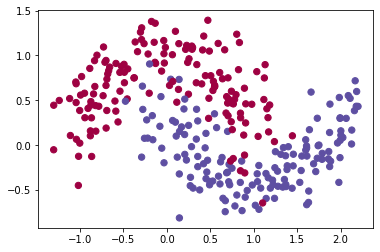

In [19]:
train_X, train_Y = load_dataset()
train_X.shape, train_Y.shape

In [22]:
def model(X,Y, layers_dims,optimizer, learning_rate=0.0007,mini_batch_size = 64, beta = 0.9, beta1 =0.9, beta2 =0.999, epsilon = 1e-8, num_epochs = 5000, print_cost = True):
  L = len(layers_dims)  # input layer 빼고 3
  costs = []
  t = 0
  seed = 10
  m = X.shape[1]
  
  parameters = initialize_parameters(layers_dims)

  if optimizer == 'gd':       # v,s 필요 없음
    pass
  elif optimizer == 'momentum':
    v = initialize_velocity(parameters)
  elif optimizer == 'adam' :
    v,s =initialize_adam(parameters)

  for i in range(num_epochs):
    seed = seed +1
    minibatches = random_mini_batches(X,Y, mini_batch_size,seed)
    cost_total = 0

    for minibatch in minibatches:
      (minibatch_X,minibatch_Y) = minibatch
      a3,caches = forward_propagation(minibatch_X,parameters)
      cost_total += compute_cost(a3,minibatch_Y)
      grads = backward_propagation(minibatch_X,minibatch_Y,caches)
      if optimizer == 'gd':
         parameters = update_parameters_with_gd(parameters,grads, learning_rate)  
      elif optimizer == 'momentum':
         parameters,v =  update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
      elif optimizer == 'adam':
         t = t + 1 # Adam counter
         parameters, v, s, _, _ = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
    cost_avg = cost_total/m    # optimizer=momentum 일 때, 1번의 epoch에서 얻는 각각의 minibatches cost들의 평균

    if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
    if print_cost and i % 100 == 0:
            costs.append(cost_avg)
  plt.plot(costs)
  plt.ylabel('cost')
  plt.xlabel('epochs (per 100)')
  plt.title("Learning rate = " + str(learning_rate))
  plt.show()

  return parameters

Cost after epoch 0: 0.702405
Cost after epoch 1000: 0.668101
Cost after epoch 2000: 0.635288
Cost after epoch 3000: 0.600491
Cost after epoch 4000: 0.573367


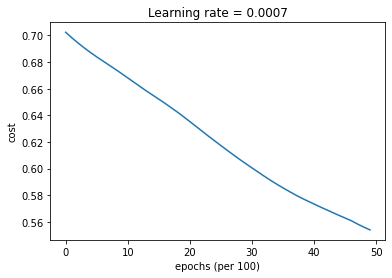

Accuracy: 0.7166666666666667


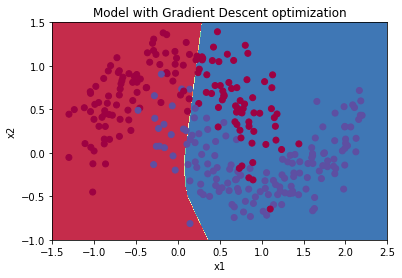

In [23]:
# 1. gd
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "gd")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

Cost after epoch 0: 0.702413
Cost after epoch 1000: 0.668167
Cost after epoch 2000: 0.635388
Cost after epoch 3000: 0.600591
Cost after epoch 4000: 0.573444


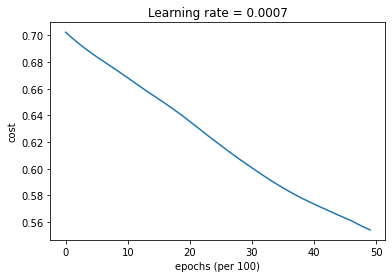

Accuracy: 0.7166666666666667


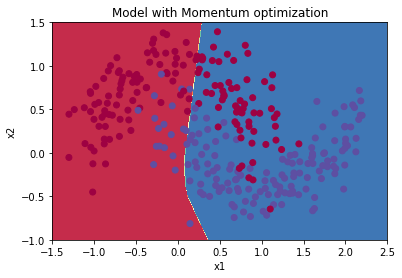

In [24]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, beta = 0.9, optimizer = "momentum")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

Cost after epoch 0: 0.702166
Cost after epoch 1000: 0.167845
Cost after epoch 2000: 0.141316
Cost after epoch 3000: 0.138788
Cost after epoch 4000: 0.136066


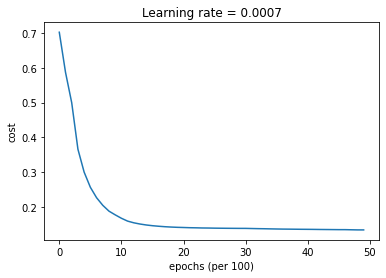

Accuracy: 0.9433333333333334


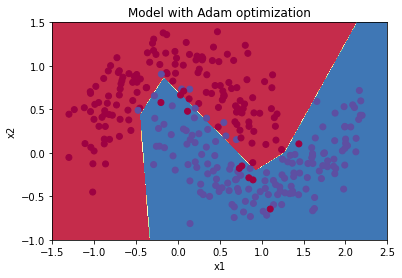

In [25]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "adam")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

In [35]:
# 위의 모델에서 learning rate 부분만 바꾼 버전
def model(X,Y, layers_dims,optimizer, learning_rate=0.0007,mini_batch_size = 64, beta = 0.9, beta1 =0.9, beta2 =0.999, epsilon = 1e-8, num_epochs = 5000, print_cost = True, decay=None, decay_rate=1):
  L = len(layers_dims)  # input layer 빼고 3
  costs = []
  t = 0
  seed = 10
  m = X.shape[1]

  lr_rates = []
  learning_rate0 = learning_rate  
  
  parameters = initialize_parameters(layers_dims)

  if optimizer == 'gd':       # v,s 필요 없음
    pass
  elif optimizer == 'momentum':
    v = initialize_velocity(parameters)
  elif optimizer == 'adam' :
    v,s =initialize_adam(parameters)

  for i in range(num_epochs):
    seed = seed +1
    minibatches = random_mini_batches(X,Y, mini_batch_size,seed)
    cost_total = 0

    for minibatch in minibatches:
      (minibatch_X,minibatch_Y) = minibatch
      a3,caches = forward_propagation(minibatch_X,parameters)
      cost_total += compute_cost(a3,minibatch_Y)
      grads = backward_propagation(minibatch_X,minibatch_Y,caches)
      if optimizer == 'gd':
         parameters = update_parameters_with_gd(parameters,grads, learning_rate)  
      elif optimizer == 'momentum':
         parameters,v =  update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
      elif optimizer == 'adam':
         t = t + 1 # Adam counter
         parameters, v, s, _, _ = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
    cost_avg = cost_total/m    # optimizer=momentum 일 때, 1번의 epoch에서 얻는 각각의 minibatches cost들의 평균

    if decay:
            learning_rate = decay(learning_rate0, i, decay_rate)
    if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
    if print_cost and i % 100 == 0:
            costs.append(cost_avg)
  plt.plot(costs)
  plt.ylabel('cost')
  plt.xlabel('epochs (per 100)')
  plt.title("Learning rate = " + str(learning_rate))
  plt.show()

  return parameters

In [32]:
def update_lr(learning_rate0,epoch_num,decay_rate):
  learning_rate = learning_rate0/(1+decay_rate*epoch_num)
  return learning_rate

In [33]:
learning_rate = 0.5
print("Original learning rate: ", learning_rate)
epoch_num = 2
decay_rate = 1
learning_rate_2 = update_lr(learning_rate, epoch_num, decay_rate)

print("Updated learning rate: ", learning_rate_2)

update_lr_test(update_lr)

Original learning rate:  0.5
Updated learning rate:  0.16666666666666666
All test passed


Cost after epoch 0: 0.701091
Cost after epoch 1000: 0.661884
Cost after epoch 2000: 0.658620
Cost after epoch 3000: 0.656765
Cost after epoch 4000: 0.655486


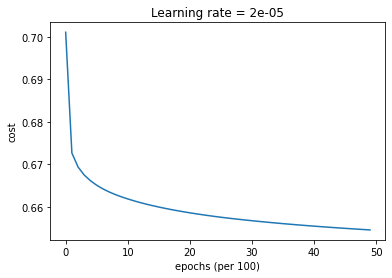

Accuracy: 0.6533333333333333


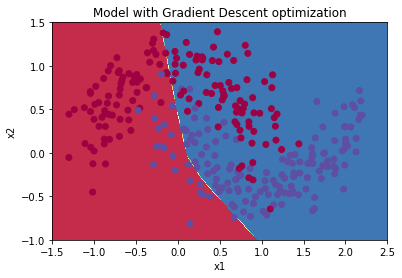

In [36]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "gd", learning_rate = 0.1, num_epochs=5000, decay=update_lr)

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

In [37]:
def schedule_lr_decay(learning_rate0,epoch_num,decay_rate,time_interval=1000):
  learning_rate = learning_rate0/(1+decay_rate*np.floor(epoch_num/time_interval))
  return learning_rate

In [38]:
learning_rate = 0.5
print("Original learning rate: ", learning_rate)

epoch_num_1 = 10
epoch_num_2 = 100
decay_rate = 0.3
time_interval = 100
learning_rate_1 = schedule_lr_decay(learning_rate, epoch_num_1, decay_rate, time_interval)
learning_rate_2 = schedule_lr_decay(learning_rate, epoch_num_2, decay_rate, time_interval)
print("Updated learning rate after {} epochs: ".format(epoch_num_1), learning_rate_1)
print("Updated learning rate after {} epochs: ".format(epoch_num_2), learning_rate_2)

schedule_lr_decay_test(schedule_lr_decay)

Original learning rate:  0.5
Updated learning rate after 10 epochs:  0.5
Updated learning rate after 100 epochs:  0.3846153846153846
All test passed


Cost after epoch 0: 0.701091
Cost after epoch 1000: 0.127161
Cost after epoch 2000: 0.120304
Cost after epoch 3000: 0.117033
Cost after epoch 4000: 0.117512


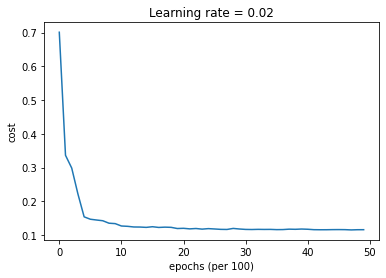

Accuracy: 0.9433333333333334


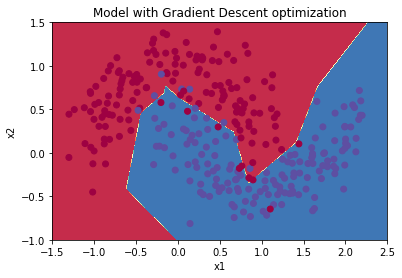

In [39]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "gd", learning_rate = 0.1, num_epochs=5000, decay=schedule_lr_decay)

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

Cost after epoch 0: 0.699346
Cost after epoch 1000: 0.130074
Cost after epoch 2000: 0.129826
Cost after epoch 3000: 0.129282
Cost after epoch 4000: 0.128361


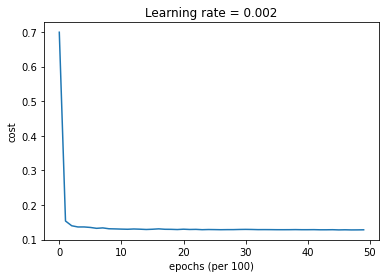

Accuracy: 0.94


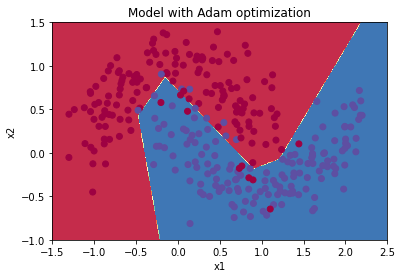

In [40]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "adam", learning_rate = 0.01, num_epochs=5000, decay=schedule_lr_decay)

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

With Mini-batch GD or Mini-batch GD with Momentum, the accuracy is significantly lower than Adam, but when learning rate decay is added on top, either can achieve performance at a speed and accuracy score that's similar to Adam.

In the case of Adam, notice that the learning curve achieves a similar accuracy but faster